### packages

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture as GMM
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift,estimate_bandwidth
from plotly.offline import plot
import plotly.graph_objs as go

# Data pre-processing
전체 데이터셋: train, 서비스업: service, 일반업: normal, 제조업: product 

In [2]:
train = pd.read_excel('C:/Users/user/Desktop/Statistical_Data_Idea_Contest/DATA/데이터/기술통계19.xlsx',index_col='global_id')
service = pd.read_excel('C:/Users/user/Desktop/Statistical_Data_Idea_Contest/DATA/데이터/실태조사_서비스업19.xlsx',index_col='global_id')
normal = pd.read_excel('C:/Users/user/Desktop/Statistical_Data_Idea_Contest/DATA/데이터/실태조사_일반항목19.xlsx',index_col='global_id')
product = pd.read_excel('C:/Users/user/Desktop/Statistical_Data_Idea_Contest/DATA/데이터/실태조사_제조업19.xlsx',index_col='global_id')

In [3]:
print('기술통계자료의 데이터 개수 train: {}'.format(len(train)))
print('실태조사 자료 데이터의 개수 sevice:{}, normal:{}, product:{}'.format(len(service), len(normal), len(product)))

기술통계자료의 데이터 개수 train: 3994
실태조사 자료 데이터의 개수 sevice:8500, normal:4000, product:7500


### 기술통계조사와 실태조사 자료의 중복자료 추출

In [4]:
warnings.filterwarnings(action='ignore')
print('기술통계조사와 실태조사 자료의 중복항목 수는 다음과 같다.')
companys = [service, normal, product]
for i in range(len(companys)):
    line = []
    for index in train.index:
        if index in companys[i].index:
            line.append(index)
        else:
            line.append(0)
    if i == 0:
        service_train =train[train.index == line]
        service_train['bt'] = 0
        print('서비스업종 데이터: {}'.format(len(service_train)))
    elif i == 1:
        normal_train =train[train.index == line]
        normal_train['bt'] = 1
        print('일반업종 데이터: {}'.format(len(normal_train)))
    else:
        product_train =train[train.index == line]
        product_train['bt'] = 2
        print('제조업종 데이터: {}'.format(len(product_train)))

기술통계조사와 실태조사 자료의 중복항목 수는 다음과 같다.
서비스업종 데이터: 195
일반업종 데이터: 183
제조업종 데이터: 834


### 데이터 병합

In [5]:
train = pd.concat([service_train, normal_train, product_train])
index_list = ['A1S1', 'A1N1', 'C2S2', 'H1_1', 'H4_1', 'I4Q1', 'I4Q2',  'I4Q3', 'I4Q4', 'I4Q5', 'I4Q6', 'I4Q7']
my_train = train.loc[:, index_list]
my_train.head(5)

,A1S1,A1N1,C2S2,H1_1,H4_1,I4Q1,I4Q2,I4Q3,I4Q4,I4Q5,I4Q6,I4Q7
global_id,,,,,,,,,,,,
111016.0,1.0,1.0,2.0,3.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,3.0
111037.0,1.0,1.0,4.0,NaN,1.0,3.0,3.0,1.0,1.0,3.0,3.0,3.0
111039.0,4.0,1.0,3.0,3.0,7.0,3.0,3.0,1.0,1.0,3.0,3.0,3.0
111041.0,4.0,5.0,2.0,5.0,NaN,3.0,3.0,3.0,3.0,2.0,2.0,2.0
111055.0,5.0,5.0,2.0,NaN,NaN,4.0,4.0,4.0,2.0,2.0,2.0,2.0


### 결측치 최빈값 처리

In [6]:
for index in index_list:
    freq = my_train[index].value_counts(dropna=True).idxmax()
    my_train[index].fillna(freq, inplace = True)
my_train.head(5)

,A1S1,A1N1,C2S2,H1_1,H4_1,I4Q1,I4Q2,I4Q3,I4Q4,I4Q5,I4Q6,I4Q7
global_id,,,,,,,,,,,,
111016.0,1.0,1.0,2.0,3.0,1.0,3.0,3.0,1.0,1.0,1.0,3.0,3.0
111037.0,1.0,1.0,4.0,3.0,1.0,3.0,3.0,1.0,1.0,3.0,3.0,3.0
111039.0,4.0,1.0,3.0,3.0,7.0,3.0,3.0,1.0,1.0,3.0,3.0,3.0
111041.0,4.0,5.0,2.0,5.0,1.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0
111055.0,5.0,5.0,2.0,3.0,1.0,4.0,4.0,4.0,2.0,2.0,2.0,2.0


### 응답범주 축소화

In [7]:
warnings.filterwarnings(action='ignore')
my_train['A1S1']=my_train['A1S1'].replace({1:1,2:1,3:2,4:3,5:3,
                                        6:1,7:4})
my_train['A1N1']=my_train['A1N1'].replace({1:1,2:1,3:4,4:3,5:3,
                                        6:3,7:4,8:3,9:3,10:2,11:2,12:3,13:5,14:5,15:5})
my_train['C2S2']=my_train['C2S2'].replace({1:1,2:2,3:3,4:2})
my_train['H1_1']=my_train['H1_1'].replace({1:3,2:1,3:1,4:2,5:2,6:2,7:2,8:4,9:4})
my_train['H4_1']=my_train['H4_1'].replace({1:1,2:4,3:1,4:2,5:3,6:3,7:5,8:6,9:5,10:6})
my_train['I4Q1']=my_train['I4Q1'].replace({1:3,2:2,3:1,4:1,5:1})
my_train['I4Q2']=my_train['I4Q2'].replace({1:3,2:2,3:1,4:1,5:1})
my_train['I4Q3']=my_train['I4Q3'].replace({1:3,2:2,3:1,4:1,5:1})
my_train['I4Q4']=my_train['I4Q4'].replace({1:3,2:2,3:1,4:1,5:1})
my_train['I4Q5']=my_train['I4Q5'].replace({1:3,2:2,3:1,4:1,5:1})
my_train['I4Q6']=my_train['I4Q6'].replace({1:3,2:2,3:1,4:1,5:1})
my_train['I4Q7']=my_train['I4Q7'].replace({1:3,2:2,3:1,4:1,5:1})
my_train.head(5)

,A1S1,A1N1,C2S2,H1_1,H4_1,I4Q1,I4Q2,I4Q3,I4Q4,I4Q5,I4Q6,I4Q7
global_id,,,,,,,,,,,,
111016.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0
111037.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0
111039.0,3.0,1.0,3.0,1.0,5.0,1.0,1.0,3.0,3.0,1.0,1.0,1.0
111041.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0
111055.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0


### 완성된 데이터원본 저장해놓기

In [8]:
my_train_original = my_train[:]

## 일반데이터

In [9]:
my_train.head(1)

,A1S1,A1N1,C2S2,H1_1,H4_1,I4Q1,I4Q2,I4Q3,I4Q4,I4Q5,I4Q6,I4Q7
global_id,,,,,,,,,,,,
111016.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0


## Dummy 데이터

In [10]:
my_train_dummy = my_train[:]
for index in index_list:
    my_train_dummy[index] = my_train_dummy[index].astype(str)
    my_train_dummy = pd.get_dummies(my_train_dummy, columns=[index])
my_train_dummy.head(1)

,A1S1_1.0,A1S1_2.0,A1S1_3.0,A1N1_1.0,A1N1_2.0,A1N1_3.0,A1N1_4.0,A1N1_5.0,C2S2_1.0,C2S2_2.0,...,I4Q4_3.0,I4Q5_1.0,I4Q5_2.0,I4Q5_3.0,I4Q6_1.0,I4Q6_2.0,I4Q6_3.0,I4Q7_1.0,I4Q7_2.0,I4Q7_3.0
global_id,,,,,,,,,,,,,,,,,,,,,
111016.0,1,0,0,1,0,0,0,0,0,1,...,1,0,0,1,1,0,0,1,0,0


## PCA(5) 데이터

In [11]:
my_train_pca = my_train[:]
pca = PCA(n_components = 10)
pca.fit(my_train_pca)
print('explained variance ratio : \n', pca.explained_variance_ratio_)
percentile = []
for i in pca.explained_variance_ratio_:
    if len(percentile) ==0:
        percentile.append(i)
    else:
        percentile.append(percentile[-1]+i)
print('PCA의 데이터반영 누적비율')
print(percentile)

my_train_pca = my_train_original[:]
pca = PCA(n_components=5).fit(my_train_pca)
my_train_pca = pca.transform(my_train_pca)
my_train_pca[0]
# 데이터 80%보존 위해 5차원 선택

explained variance ratio : 
 [0.35642749 0.14419324 0.12225631 0.09554744 0.0678242  0.06109995
 0.03931391 0.03524449 0.02638728 0.02292691]
PCA의 데이터반영 누적비율
[0.35642749132456547, 0.5006207312815825, 0.6228770410695439, 0.7184244847512617, 0.786248689115913, 0.8473486419952504, 0.8866625502120182, 0.9219070430219293, 0.9482943232583957, 0.9712212336673715]


array([-0.28380171, -0.96117894, -1.28586227,  0.37469963, -0.83738636])

## Dummy+PCA(9) 데이터

In [12]:
my_train_dummy_pca = my_train_dummy[:]

pca = PCA(n_components = 10)
pca.fit(my_train_dummy_pca)
print('explained variance ratio : \n', pca.explained_variance_ratio_)
percentile = []
for i in pca.explained_variance_ratio_:
    if len(percentile) ==0:
        percentile.append(i)
    else:
        percentile.append(percentile[-1]+i)
print('PCA의 데이터반영 누적 비율')
print(percentile)

my_train_dummy_pca = my_train_dummy[:]
pca = PCA(n_components=9).fit(my_train_dummy_pca)
my_train_dummy_pca = pca.transform(my_train_dummy_pca)
# 70% 이상의 보존위해 9차원 선택!
my_train_dummy_pca[0]

explained variance ratio : 
 [0.23216044 0.1132267  0.08005131 0.06432944 0.0568813  0.05458424
 0.04840321 0.03558971 0.03466758 0.03258187]
PCA의 데이터반영 누적 비율
[0.23216043589529556, 0.34538713290920087, 0.42543843818257254, 0.4897678777203789, 0.5466491771477184, 0.6012334218227604, 0.6496366348123314, 0.6852263432176935, 0.7198939253963582, 0.7524757964897848]


array([ 0.37763065, -0.66241984,  1.24133012, -0.26000766, -0.44947621,
       -0.51229299, -0.19584626,  0.29122822,  0.40403731])

# K-MEANS 클러스터

In [13]:
# 일반
model = KMeans(n_clusters=3)
model.fit(my_train)
kmeans_predict = model.fit_predict(my_train)
my_train_original['k_means'] = kmeans_predict
# 더미
model.fit(my_train_dummy)
kmeans_dummy_predict = model.fit_predict(my_train_dummy)
my_train_original['k_means_dummy'] = kmeans_dummy_predict


#PCA
model.fit(my_train_pca)
kmeans_pca_predict = model.fit_predict(my_train_pca)
my_train_original['k_means_pca'] = kmeans_pca_predict

#Dummy+PCA
model.fit(my_train_dummy_pca)
kmeans_dummy_pca_predict = model.fit_predict(my_train_dummy_pca)
my_train_original['k_means_dummy_pca'] = kmeans_dummy_pca_predict

# Spectral 군집

In [14]:
#일반
spectral = SpectralClustering(n_clusters=3, n_init=10)
spectral_predict = spectral.fit_predict(my_train)
my_train_original['Spectral'] = spectral_predict
#Dummy
spectral_dummy_predict = spectral.fit_predict(my_train_dummy)
my_train_original['Spectral_dummy'] = spectral_dummy_predict
# PCA
spectral_pca_predict = spectral.fit_predict(my_train_pca)
my_train_original['Spectral_pca'] = spectral_pca_predict
# Dummy+PCA
spectral_dummy_pca_predict = spectral.fit_predict(my_train_dummy_pca)
my_train_original['Spectral_dummy_pca'] = spectral_dummy_pca_predict


# GMM

In [15]:
#일반
gmm = GMM(n_components=3).fit(my_train)
gmm_predict=gmm.predict(my_train)
my_train_original['gmm'] = gmm_predict
#PCA
gmm_pca = GMM(n_components=3).fit(my_train_pca)
gmm_pca_predict=gmm_pca.predict(my_train_pca)
my_train_original['gmm_pca'] = gmm_pca_predict
#dummy
gmm_dummy = GMM(n_components=3).fit(my_train_dummy)
gmm_dummy_predict=gmm_dummy.predict(my_train_dummy)
my_train_original['gmm_dummy'] = gmm_dummy_predict
#dummy_pca
gmm_dummy_pca = GMM(n_components=3).fit(my_train_dummy_pca)
gmm_dummy_pca_predict=gmm_dummy_pca.predict(my_train_dummy_pca)
my_train_original['gmm_dummy_pca'] = gmm_dummy_pca_predict

# AGG

In [16]:
#일반
agg = AgglomerativeClustering(n_clusters=3).fit(my_train)
agg_predict=agg.fit_predict(my_train)
my_train_original['agg'] = agg_predict
#PCA
agg_pca = AgglomerativeClustering(n_clusters=3).fit(my_train_pca)
agg_pca_predict=agg_pca.fit_predict(my_train_pca)
my_train_original['agg_pca'] = agg_pca_predict
#dummy
agg_dummy = AgglomerativeClustering(n_clusters=3).fit(my_train_dummy)
agg_dummy_predict=agg_dummy.fit_predict(my_train_dummy)
my_train_original['agg_dummy'] = agg_dummy_predict
#dummy_pca
agg_dummy_pca = AgglomerativeClustering(n_clusters=3).fit(my_train_dummy_pca)
agg_dummy_pca_predict=agg_dummy_pca.fit_predict(my_train_dummy_pca)
my_train_original['agg_dummy_pca'] = agg_dummy_pca_predict
my_train_original.head(5)

,A1S1,A1N1,C2S2,H1_1,H4_1,I4Q1,I4Q2,I4Q3,I4Q4,I4Q5,...,Spectral_pca,Spectral_dummy_pca,gmm,gmm_pca,gmm_dummy,gmm_dummy_pca,agg,agg_pca,agg_dummy,agg_dummy_pca
global_id,,,,,,,,,,,,,,,,,,,,,
111016.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,...,0,0,2,2,1,2,0,0,0,0
111037.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,...,0,0,1,2,1,2,0,0,0,0
111039.0,3.0,1.0,3.0,1.0,5.0,1.0,1.0,3.0,3.0,1.0,...,2,0,1,0,1,2,1,2,0,0
111041.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,...,0,0,2,2,1,2,2,0,1,1
111055.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,0,0,2,2,1,2,2,0,1,1


# DBSCAN

In [17]:
model = DBSCAN(eps=2.4,min_samples=150)

#일반
dbscan = model.fit(my_train)
dbscan_predict=dbscan.fit_predict(my_train)
my_train_original['dbscan'] = dbscan_predict
#PCA
dbscan_pca = model.fit(my_train_pca)
dbscan_pca_predict=dbscan_pca.fit_predict(my_train_pca)
my_train_original['dbscan_pca'] = dbscan_pca_predict
#dummy
dbscan_dummy = model.fit(my_train_dummy)
dbscan_dummy_predict=dbscan_dummy.fit_predict(my_train_dummy)
my_train_original['dbscan_dummy'] = dbscan_dummy_predict
#dummy_pca
dbscan_dummy_pca = model.fit(my_train_dummy_pca)
dbscan_dummy_pca_predict=dbscan_dummy_pca.fit_predict(my_train_dummy_pca)
my_train_original['dbscan_dummy_pca'] = dbscan_dummy_pca_predict
my_train_original.head(5)

,A1S1,A1N1,C2S2,H1_1,H4_1,I4Q1,I4Q2,I4Q3,I4Q4,I4Q5,...,gmm_dummy,gmm_dummy_pca,agg,agg_pca,agg_dummy,agg_dummy_pca,dbscan,dbscan_pca,dbscan_dummy,dbscan_dummy_pca
global_id,,,,,,,,,,,,,,,,,,,,,
111016.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,...,1,2,0,0,0,0,1,0,-1,0
111037.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,1.0,...,1,2,0,0,0,0,1,0,0,0
111039.0,3.0,1.0,3.0,1.0,5.0,1.0,1.0,3.0,3.0,1.0,...,1,2,1,2,0,0,-1,0,-1,0
111041.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1,2,2,0,1,1,1,0,-1,0
111055.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,1,2,2,0,1,1,1,0,-1,0


# MEAN_SHIFT

In [18]:
bandwidth_X = estimate_bandwidth(my_train,quantile=0.1,n_samples=len(my_train))
model = MeanShift(bandwidth=bandwidth_X,bin_seeding=True)
# 일반

model.fit(my_train)
meanshift_predict = model.fit_predict(my_train)
my_train_original['meanshift'] = meanshift_predict
# 더미
# model.fit(my_train_dummy)
# meanshift_dummy_predict = model.fit_predict(my_train_dummy)
# my_train_original['meanshift_dummy'] = meanshift_dummy_predict


#PCA
model.fit(my_train_pca)
meanshift_pca_predict = model.fit_predict(my_train_pca)
my_train_original['meanshift_pca'] = meanshift_pca_predict

#Dummy+PCA
model.fit(my_train_dummy_pca)
meanshift_dummy_pca_predict = model.fit_predict(my_train_dummy_pca)
my_train_original['meanshift_dummy_pca'] = meanshift_dummy_pca_predict


# 시각화 ( 결과 판단)

## 실루엣스코어

In [19]:
print('K-means  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, kmeans_predict)))
print('K-means_dummy  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, kmeans_dummy_predict)))
print('K-means_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, kmeans_pca_predict)))
print('K-means_dummy_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, kmeans_dummy_pca_predict)))
print('----------------------')
print('Spectral  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, spectral_predict)))
print('Spectral_dummy  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, spectral_dummy_predict)))
print('Spectral_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, spectral_pca_predict)))
print('Spectral_dummy_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, spectral_dummy_pca_predict)))
print('----------------------')
print('GMM  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, gmm_predict)))
print('GMM_dummy  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, gmm_dummy_predict)))
print('GMM_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, gmm_pca_predict)))
print('GMM_dummy_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, gmm_dummy_pca_predict)))
print('----------------------')
print('AGG  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, agg_predict)))
print('AGG_dummy  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, agg_dummy_predict)))
print('AGG_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, agg_pca_predict)))
print('AGG_dummy_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, agg_dummy_pca_predict)))
print('----------------------')
print('DBscan  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, dbscan_predict)))
print('DBscan_dummy  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, dbscan_dummy_predict)))
print('DBscan_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, dbscan_pca_predict)))
# print('DBscan_dummy_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, dbscan_dummy_pca_predict)))
print('----------------------')
print('Meanshift  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, meanshift_predict)))
# print('Meanshift_dummy  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, meanshift_dummy_predict)))
# print('Meanshift_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, meanshift_pca_predict)))
# print('Meanshift_dummy_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, meanshift_dummy_pca_predict)))


K-means  - silhouette score: 0.290
K-means_dummy  - silhouette score: 0.247
K-means_pca  - silhouette score: 0.284
K-means_dummy_pca  - silhouette score: 0.246
----------------------
Spectral  - silhouette score: 0.182
Spectral_dummy  - silhouette score: 0.250
Spectral_pca  - silhouette score: 0.140
Spectral_dummy_pca  - silhouette score: 0.232
----------------------
GMM  - silhouette score: 0.205
GMM_dummy  - silhouette score: 0.239
GMM_pca  - silhouette score: 0.041
GMM_dummy_pca  - silhouette score: 0.145
----------------------
AGG  - silhouette score: 0.243
AGG_dummy  - silhouette score: 0.183
AGG_pca  - silhouette score: 0.269
AGG_dummy_pca  - silhouette score: 0.214
----------------------
DBscan  - silhouette score: 0.219
DBscan_dummy  - silhouette score: 0.141
DBscan_pca  - silhouette score: 0.194
----------------------
Meanshift  - silhouette score: 0.333


# 결과중간저장

In [33]:
# 어떤모델이 최고일까?
my_train_original.head(5)
index_list = ['Spectral','Spectral_dummy', 'agg','agg_pca']
my_train_final = my_train_original.loc[:, index_list]
my_train_final.head(5)
my_train_final.to_csv('C:/Users/user/Desktop/Statistical_Data_Idea_Contest/0430/kyumin/result.csv', index=True)

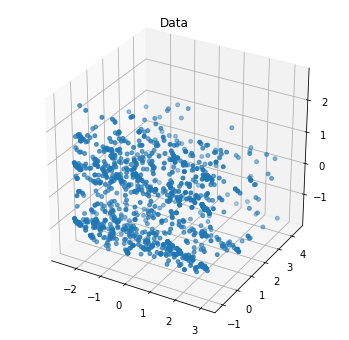

In [34]:
my_train_show = my_train[:]
pca = PCA(n_components=3).fit(my_train_show)
pca_train = pca.transform(my_train_show)
plt.rcParams["figure.figsize"] = (6,6)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_train[:, 0], pca_train[:, 1], pca_train[:,2], marker='o', s=15)
ax.set_title('Data')
plt.show()


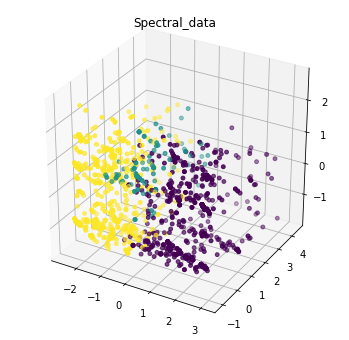

In [35]:
plt.rcParams["figure.figsize"] = (6,6)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_train[:, 0], pca_train[:, 1], pca_train[:,2], c=spectral_dummy_predict, marker='o', s=15)
ax.set_title('Spectral_data')
plt.show()

In [36]:
def bar_chart(feature):
    group_0 = my_train_original[my_train_original['spectral_cluster']==0][feature].value_counts()
    group_1 = my_train_original[my_train_original['spectral_cluster']==1][feature].value_counts()
    group_2 = my_train_original[my_train_original['spectral_cluster']==2][feature].value_counts()
    df = pd.DataFrame([group_0,group_1,group_2])
    df.index = ['group_0','group_1','group_2']
    df.plot(kind='bar',stacked=True, figsize=(10,5), title = feature)

In [37]:
features = ['A1S1','A1N1','C2S2','H1_1','H4_1','I4Q1','I4Q2','I4Q3','I4Q4','I4Q5','I4Q6','I4Q7']

In [40]:
for i in range(3):
    for feature in features:
        print('{}번쨰그룹의 {}feature 개수'.format(i, feature))
        print(my_train_original[my_train_original['Spectral_dummy']==i][feature].value_counts(normalize=True))

0번쨰그룹의 A1S1feature 개수
1.0    0.747148
3.0    0.193916
2.0    0.058935
Name: A1S1, dtype: float64
0번쨰그룹의 A1N1feature 개수
1.0    0.509506
3.0    0.403042
2.0    0.072243
4.0    0.011407
5.0    0.003802
Name: A1N1, dtype: float64
0번쨰그룹의 C2S2feature 개수
2.0    0.621673
1.0    0.323194
3.0    0.055133
Name: C2S2, dtype: float64
0번쨰그룹의 H1_1feature 개수
1.0    0.522814
2.0    0.264259
3.0    0.209125
4.0    0.003802
Name: H1_1, dtype: float64
0번쨰그룹의 H4_1feature 개수
1.0    0.697719
3.0    0.152091
2.0    0.074144
4.0    0.036122
5.0    0.022814
6.0    0.017110
Name: H4_1, dtype: float64
0번쨰그룹의 I4Q1feature 개수
3.0    0.828897
2.0    0.163498
1.0    0.007605
Name: I4Q1, dtype: float64
0번쨰그룹의 I4Q2feature 개수
3.0    0.802281
2.0    0.190114
1.0    0.007605
Name: I4Q2, dtype: float64
0번쨰그룹의 I4Q3feature 개수
3.0    0.692015
2.0    0.275665
1.0    0.032319
Name: I4Q3, dtype: float64
0번쨰그룹의 I4Q4feature 개수
3.0    0.684411
2.0    0.296578
1.0    0.019011
Name: I4Q4, dtype: float64
0번쨰그룹의 I4Q5feature 개수
3.0    0.

In [42]:
# 최종 클러스터 분포
my_train_original['Spectral_dummy'].value_counts()

2    563
0    526
1    123
Name: Spectral_dummy, dtype: int64

# 18가지 클러스터 (최종결과)
> 동석씨 도움받아야함. 0430/final_cluster 코드통합실패

In [55]:
gisul_train = pd.read_excel('C:/Users/user/Desktop/Statistical_Data_Idea_Contest/DATA/데이터/기술통계19.xlsx',index_col='global_id')
cluster = pd.read_csv('C:/Users/user/Desktop/Statistical_Data_Idea_Contest/0430/kyumin/result.csv',index_col='global_id')

기술통계19_new.csv 는 기술통계 자료에서 서비스+제조+일반 업종만 추출한 자료이다.

In [60]:
Spectral_dummy = cluster.Spectral_dummy

In [61]:
def final_cluster(gisul_train,method):
    gisul_train['cluster'] = method
    features = ['05-Sep','bt','cluster']
    
    gisul_train = gisul_train[features].copy()
    gisul_train['05-Sep']=gisul_train['05-Sep'].replace({4:1})
    gisul_train['bt']=gisul_train['bt'].replace({2:1,3:2})
    gisul_train['cluster']= gisul_train['cluster'].replace({0:3})
    gisul_train['bt']=gisul_train['bt'].replace({1:10,2:20})
    gisul_train['05-Sep']= gisul_train['05-Sep'].replace({1:100,2:200,3:300})
    
    gisul_train['new_cluster'] = gisul_train['05-Sep']+gisul_train['bt']+gisul_train['cluster']
    
    return gisul_train

In [62]:
Spectral_dummy_cluster = final_cluster(gisul_train,Spectral_dummy)

ValueError: cannot reindex from a duplicate axis

In [59]:
Spectral_dummy_cluster['new_cluster'].value_counts() # 이걸로 선정

NameError: name 'Spectral_dummy_cluster' is not defined